In [1]:
#(unbalanced)logistic_regression

In [2]:
import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    matthews_corrcoef, precision_score, roc_curve, auc
)

df = pd.read_csv('Unbalanced_hotel_data.csv')

In [3]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (60202, 55)
Validation set size: (12900, 55)
Test set size: (12901, 55)


In [4]:
unique_labels = np.unique(y)
class_weights = {
    cls: len(y) / (len(unique_labels) * sum(y == cls))
    for cls in unique_labels
}

In [5]:
def print_classification_metrics(model, X_data, y_true, dataset_label="Dataset"):
    y_pred = model.predict(X_data)
    print(f"\n=== Classification Report ({dataset_label}) ===")
    print(classification_report(y_true, y_pred, digits=4))

    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    print(f"Accuracy:  {acc:.4f}")
    print(f"MCC:       {mcc:.4f}")
    print(f"Precision: {prec:.4f}")

In [6]:
def plot_confusion_matrix_and_roc(model, X_data, y_true, dataset_label="Dataset"):

    y_pred = model.predict(X_data)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{dataset_label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    y_prob = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.title(f"{dataset_label} ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print(f"{dataset_label} AUC: {roc_auc:.4f}")


=== Classification Report (TRAIN (Base)) ===
              precision    recall  f1-score   support

           0     0.8816    0.6890    0.7735     43518
           1     0.4833    0.7588    0.5905     16684

    accuracy                         0.7083     60202
   macro avg     0.6825    0.7239    0.6820     60202
weighted avg     0.7713    0.7083    0.7228     60202

Accuracy:  0.7083
MCC:       0.4042
Precision: 0.7713

=== Classification Report (VALIDATION (Base)) ===
              precision    recall  f1-score   support

           0     0.8828    0.6924    0.7761      9325
           1     0.4866    0.7603    0.5934      3575

    accuracy                         0.7112     12900
   macro avg     0.6847    0.7264    0.6848     12900
weighted avg     0.7730    0.7112    0.7255     12900

Accuracy:  0.7112
MCC:       0.4089
Precision: 0.7730

=== Classification Report (TEST (Base)) ===
              precision    recall  f1-score   support

           0     0.8761    0.6860    0.76

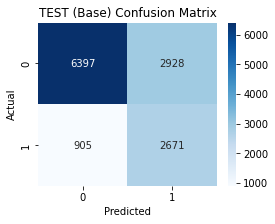

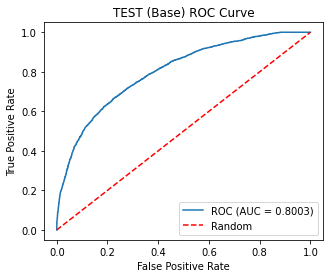

TEST (Base) AUC: 0.8003


In [7]:
base_lr = LogisticRegression(
    random_state=42,
    class_weight=class_weights,
    solver='liblinear'
)
base_lr.fit(X_train, y_train)

print_classification_metrics(base_lr, X_train, y_train, "TRAIN (Base)")
print_classification_metrics(base_lr, X_val,   y_val,   "VALIDATION (Base)")
print_classification_metrics(base_lr, X_test,  y_test,  "TEST (Base)")

plot_confusion_matrix_and_roc(base_lr, X_test, y_test, "TEST (Base)")

In [8]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

lr_for_grid = LogisticRegression(
    random_state=42,
    class_weight=class_weights
)

grid_search_lr = GridSearchCV(
    lr_for_grid,
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

print("\nBest parameters (Logistic Regression):", grid_search_lr.best_params_)
print("Best CV ROC-AUC score (from GridSearch):", grid_search_lr.best_score_)


Best parameters (Logistic Regression): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV ROC-AUC score (from GridSearch): 0.8145324303136213



=== Classification Report (TRAIN (Tuned)) ===
              precision    recall  f1-score   support

           0     0.8840    0.6957    0.7786     43518
           1     0.4898    0.7619    0.5962     16684

    accuracy                         0.7140     60202
   macro avg     0.6869    0.7288    0.6874     60202
weighted avg     0.7747    0.7140    0.7281     60202

Accuracy:  0.7140
MCC:       0.4136
Precision: 0.7747

=== Classification Report (VALIDATION (Tuned)) ===
              precision    recall  f1-score   support

           0     0.8862    0.6996    0.7819      9325
           1     0.4942    0.7656    0.6007      3575

    accuracy                         0.7179     12900
   macro avg     0.6902    0.7326    0.6913     12900
weighted avg     0.7776    0.7179    0.7317     12900

Accuracy:  0.7179
MCC:       0.4207
Precision: 0.7776

=== Classification Report (TEST (Tuned)) ===
              precision    recall  f1-score   support

           0     0.8779    0.6924    0

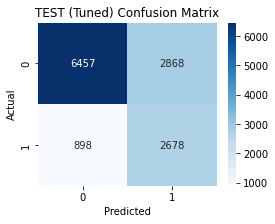

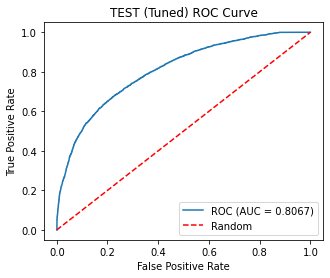

TEST (Tuned) AUC: 0.8067

===== Comparison of Test Performance to CV Best Score =====
Cross-validation best score (AUC): 0.8145324303136213


In [9]:
best_lr = LogisticRegression(
    **grid_search_lr.best_params_,
    random_state=42,
    class_weight=class_weights
)
best_lr.fit(X_train, y_train)

print_classification_metrics(best_lr, X_train, y_train, "TRAIN (Tuned)")
print_classification_metrics(best_lr, X_val,   y_val,   "VALIDATION (Tuned)")
print_classification_metrics(best_lr, X_test,  y_test,  "TEST (Tuned)")

plot_confusion_matrix_and_roc(best_lr, X_test, y_test, "TEST (Tuned)")

print("\n===== Comparison of Test Performance to CV Best Score =====")
print("Cross-validation best score (AUC):", grid_search_lr.best_score_)

In [10]:
#(balanced)logistic_regression

In [11]:
df = pd.read_csv('Balanced_hotel_data.csv')

In [12]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (33369, 55)
Validation set size: (7150, 55)
Test set size: (7151, 55)


In [13]:
unique_labels = np.unique(y)
class_weights = {
    cls: len(y) / (len(unique_labels) * sum(y == cls))
    for cls in unique_labels
}

In [14]:
def print_classification_metrics(model, X_data, y_true, dataset_label="Dataset"):
    y_pred = model.predict(X_data)
    print(f"\n=== Classification Report ({dataset_label}) ===")
    print(classification_report(y_true, y_pred, digits=4))

    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    print(f"Accuracy:  {acc:.4f}")
    print(f"MCC:       {mcc:.4f}")
    print(f"Precision: {prec:.4f}")

In [15]:
def plot_confusion_matrix_and_roc(model, X_data, y_true, dataset_label="Dataset"):

    y_pred = model.predict(X_data)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{dataset_label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    y_prob = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.title(f"{dataset_label} ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print(f"{dataset_label} AUC: {roc_auc:.4f}")


=== Classification Report (TRAIN (Base)) ===
              precision    recall  f1-score   support

           0     0.7401    0.6851    0.7115     16684
           1     0.7069    0.7594    0.7322     16685

    accuracy                         0.7223     33369
   macro avg     0.7235    0.7223    0.7219     33369
weighted avg     0.7235    0.7223    0.7219     33369

Accuracy:  0.7223
MCC:       0.4457
Precision: 0.7235

=== Classification Report (VALIDATION (Base)) ===
              precision    recall  f1-score   support

           0     0.7274    0.6764    0.7010      3575
           1     0.6976    0.7466    0.7213      3575

    accuracy                         0.7115      7150
   macro avg     0.7125    0.7115    0.7111      7150
weighted avg     0.7125    0.7115    0.7111      7150

Accuracy:  0.7115
MCC:       0.4240
Precision: 0.7125

=== Classification Report (TEST (Base)) ===
              precision    recall  f1-score   support

           0     0.7367    0.6910    0.71

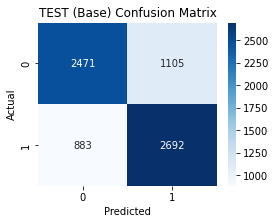

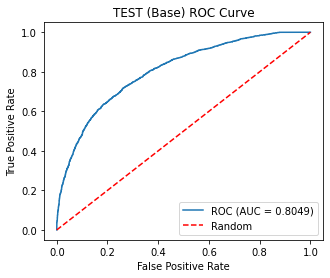

TEST (Base) AUC: 0.8049


In [16]:
base_lr = LogisticRegression(
    random_state=42,
    class_weight=class_weights,
    solver='liblinear'
)
base_lr.fit(X_train, y_train)

print_classification_metrics(base_lr, X_train, y_train, "TRAIN (Base)")
print_classification_metrics(base_lr, X_val,   y_val,   "VALIDATION (Base)")
print_classification_metrics(base_lr, X_test,  y_test,  "TEST (Base)")

plot_confusion_matrix_and_roc(base_lr, X_test, y_test, "TEST (Base)")

In [17]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']}

lr_for_grid = LogisticRegression(
    random_state=42,
    class_weight=class_weights
)

grid_search_lr = GridSearchCV(
    lr_for_grid,
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

print("\nBest parameters (Logistic Regression):", grid_search_lr.best_params_)
print("Best CV ROC-AUC score (from GridSearch):", grid_search_lr.best_score_)


Best parameters (Logistic Regression): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV ROC-AUC score (from GridSearch): 0.8119980578091269



=== Classification Report (TRAIN (Tuned)) ===
              precision    recall  f1-score   support

           0     0.7474    0.6950    0.7203     16684
           1     0.7150    0.7651    0.7392     16685

    accuracy                         0.7301     33369
   macro avg     0.7312    0.7301    0.7297     33369
weighted avg     0.7312    0.7301    0.7297     33369

Accuracy:  0.7301
MCC:       0.4613
Precision: 0.7312

=== Classification Report (VALIDATION (Tuned)) ===
              precision    recall  f1-score   support

           0     0.7350    0.6876    0.7105      3575
           1     0.7065    0.7522    0.7286      3575

    accuracy                         0.7199      7150
   macro avg     0.7208    0.7199    0.7196      7150
weighted avg     0.7208    0.7199    0.7196      7150

Accuracy:  0.7199
MCC:       0.4406
Precision: 0.7208

=== Classification Report (TEST (Tuned)) ===
              precision    recall  f1-score   support

           0     0.7446    0.7019    0

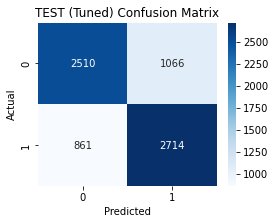

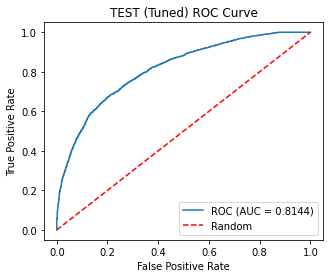

TEST (Tuned) AUC: 0.8144

===== Comparison of Test Performance to CV Best Score =====
Cross-validation best score (AUC): 0.8119980578091269


In [18]:
best_lr = LogisticRegression(
    **grid_search_lr.best_params_,
    random_state=42,
    class_weight=class_weights
)
best_lr.fit(X_train, y_train)

print_classification_metrics(best_lr, X_train, y_train, "TRAIN (Tuned)")
print_classification_metrics(best_lr, X_val,   y_val,   "VALIDATION (Tuned)")
print_classification_metrics(best_lr, X_test,  y_test,  "TEST (Tuned)")

plot_confusion_matrix_and_roc(best_lr, X_test, y_test, "TEST (Tuned)")

print("\n===== Comparison of Test Performance to CV Best Score =====")
print("Cross-validation best score (AUC):", grid_search_lr.best_score_)

In [19]:
#(unbalanced)xg boost

In [20]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    matthews_corrcoef, precision_score, roc_curve, auc
)
import xgboost as xgb

df = pd.read_csv('Unbalanced_hotel_data.csv')


Defaulting to user installation because normal site-packages is not writeable


In [21]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (60202, 55)
Validation set size: (12900, 55)
Test set size: (12901, 55)


In [22]:
unique_labels = np.unique(y)
class_weights = {
    cls: len(y) / (len(unique_labels) * sum(y == cls))
    for cls in unique_labels
}


In [23]:
def print_classification_metrics(model, X_data, y_true, dataset_label="Dataset"):
    y_pred = model.predict(X_data)
    print(f"\n=== Classification Report ({dataset_label}) ===")
    print(classification_report(y_true, y_pred, digits=4))
    
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    print(f"Accuracy:  {acc:.4f}")
    print(f"MCC:       {mcc:.4f}")
    print(f"Precision: {prec:.4f}")

In [24]:
def plot_confusion_matrix_and_roc(model, X_data, y_true, dataset_label="Dataset"):

    y_pred = model.predict(X_data)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{dataset_label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    y_prob = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.title(f"{dataset_label} ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    print(f"{dataset_label} AUC: {roc_auc:.4f}")


=== Classification Report (TRAIN (Base)) ===
              precision    recall  f1-score   support

           0     0.9209    0.8056    0.8594     43518
           1     0.6177    0.8195    0.7044     16684

    accuracy                         0.8094     60202
   macro avg     0.7693    0.8125    0.7819     60202
weighted avg     0.8369    0.8094    0.8164     60202

Accuracy:  0.8094
MCC:       0.5802
Precision: 0.8369

=== Classification Report (VALIDATION (Base)) ===
              precision    recall  f1-score   support

           0     0.8924    0.7854    0.8355      9325
           1     0.5736    0.7530    0.6512      3575

    accuracy                         0.7764     12900
   macro avg     0.7330    0.7692    0.7433     12900
weighted avg     0.8041    0.7764    0.7844     12900

Accuracy:  0.7764
MCC:       0.5009
Precision: 0.8041

=== Classification Report (TEST (Base)) ===
              precision    recall  f1-score   support

           0     0.8856    0.7787    0.82

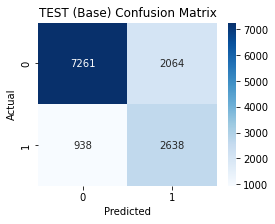

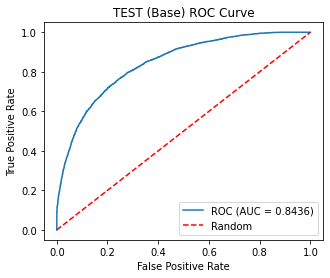

TEST (Base) AUC: 0.8436


In [25]:
base_xgb = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=class_weights[1] / class_weights[0],
    eval_metric='logloss'
)

base_xgb.fit(X_train, y_train)

print_classification_metrics(base_xgb, X_train, y_train, "TRAIN (Base)")
print_classification_metrics(base_xgb, X_val, y_val, "VALIDATION (Base)")
print_classification_metrics(base_xgb, X_test, y_test, "TEST (Base)")

plot_confusion_matrix_and_roc(base_xgb, X_test, y_test, "TEST (Base)")

In [26]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    base_xgb,
    param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

print("\nBest parameters (XGBoost):", grid_search_xgb.best_params_)
print("Best CV ROC-AUC score (from GridSearch):", grid_search_xgb.best_score_)


Best parameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC-AUC score (from GridSearch): 0.8526268152910402



=== Classification Report (TRAIN (Tuned)) ===
              precision    recall  f1-score   support

           0     0.9257    0.8138    0.8662     43518
           1     0.6308    0.8297    0.7167     16684

    accuracy                         0.8182     60202
   macro avg     0.7783    0.8217    0.7914     60202
weighted avg     0.8440    0.8182    0.8247     60202

Accuracy:  0.8182
MCC:       0.5984
Precision: 0.8440

=== Classification Report (VALIDATION (Tuned)) ===
              precision    recall  f1-score   support

           0     0.8929    0.7891    0.8378      9325
           1     0.5778    0.7530    0.6539      3575

    accuracy                         0.7791     12900
   macro avg     0.7353    0.7710    0.7458     12900
weighted avg     0.8055    0.7791    0.7868     12900

Accuracy:  0.7791
MCC:       0.5051
Precision: 0.8055

=== Classification Report (TEST (Tuned)) ===
              precision    recall  f1-score   support

           0     0.8865    0.7842    0

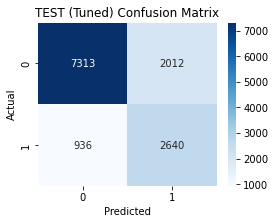

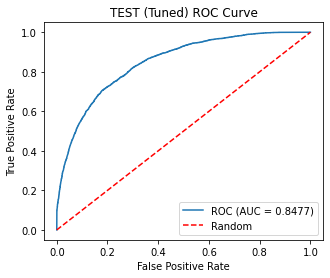

TEST (Tuned) AUC: 0.8477

===== Comparison of Test Performance to CV Best Score =====
Cross-validation best score (AUC): 0.8526268152910402


In [27]:
best_xgb = xgb.XGBClassifier(
    **grid_search_xgb.best_params_,
    random_state=42,
    scale_pos_weight=class_weights[1] / class_weights[0],
    eval_metric='logloss'
)
best_xgb.fit(X_train, y_train)

print_classification_metrics(best_xgb, X_train, y_train, "TRAIN (Tuned)")
print_classification_metrics(best_xgb, X_val, y_val, "VALIDATION (Tuned)")
print_classification_metrics(best_xgb, X_test, y_test, "TEST (Tuned)")

plot_confusion_matrix_and_roc(best_xgb, X_test, y_test, "TEST (Tuned)")

print("\n===== Comparison of Test Performance to CV Best Score =====")
print("Cross-validation best score (AUC):", grid_search_xgb.best_score_)

In [28]:
#(balanced)xg boost

In [29]:
df = pd.read_csv('Balanced_hotel_data.csv')

X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (33369, 55)
Validation set size: (7150, 55)
Test set size: (7151, 55)


In [30]:
unique_labels = np.unique(y)
class_weights = {
    cls: len(y) / (len(unique_labels) * sum(y == cls))
    for cls in unique_labels
}

In [31]:
def print_classification_metrics(model, X_data, y_true, dataset_label="Dataset"):

    y_pred = model.predict(X_data)
    print(f"\n=== Classification Report ({dataset_label}) ===")
    print(classification_report(y_true, y_pred, digits=4))
    
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    print(f"Accuracy:  {acc:.4f}")
    print(f"MCC:       {mcc:.4f}")
    print(f"Precision: {prec:.4f}")

In [32]:
def plot_confusion_matrix_and_roc(model, X_data, y_true, dataset_label="Dataset"):

    y_pred = model.predict(X_data)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{dataset_label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    y_prob = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.title(f"{dataset_label} ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    print(f"{dataset_label} AUC: {roc_auc:.4f}")



=== Classification Report (TRAIN (Base)) ===
              precision    recall  f1-score   support

           0     0.8169    0.8066    0.8117     16684
           1     0.8090    0.8192    0.8141     16685

    accuracy                         0.8129     33369
   macro avg     0.8129    0.8129    0.8129     33369
weighted avg     0.8129    0.8129    0.8129     33369

Accuracy:  0.8129
MCC:       0.6258
Precision: 0.8129

=== Classification Report (VALIDATION (Base)) ===
              precision    recall  f1-score   support

           0     0.7552    0.7628    0.7590      3575
           1     0.7604    0.7527    0.7565      3575

    accuracy                         0.7578      7150
   macro avg     0.7578    0.7578    0.7578      7150
weighted avg     0.7578    0.7578    0.7578      7150

Accuracy:  0.7578
MCC:       0.5156
Precision: 0.7578

=== Classification Report (TEST (Base)) ===
              precision    recall  f1-score   support

           0     0.7733    0.7651    0.76

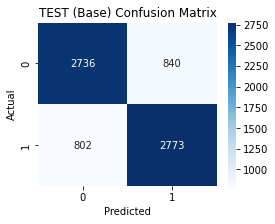

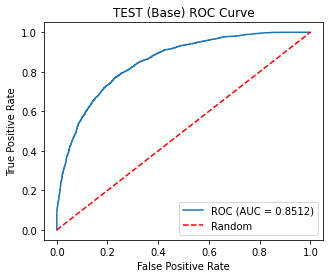

TEST (Base) AUC: 0.8512


In [33]:
base_xgb = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=class_weights[1] / class_weights[0],
    eval_metric='logloss'
)

base_xgb.fit(X_train, y_train)

print_classification_metrics(base_xgb, X_train, y_train, "TRAIN (Base)")
print_classification_metrics(base_xgb, X_val, y_val, "VALIDATION (Base)")
print_classification_metrics(base_xgb, X_test, y_test, "TEST (Base)")

plot_confusion_matrix_and_roc(base_xgb, X_test, y_test, "TEST (Base)")

In [34]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [35]:
grid_search_xgb = GridSearchCV(
    base_xgb,
    param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [36]:
grid_search_xgb.fit(X_train, y_train)

print("\nBest parameters (XGBoost):", grid_search_xgb.best_params_)
print("Best CV ROC-AUC score (from GridSearch):", grid_search_xgb.best_score_)



Best parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC-AUC score (from GridSearch): 0.8484151046622864



=== Classification Report (TRAIN (Tuned)) ===
              precision    recall  f1-score   support

           0     0.8304    0.8184    0.8244     16684
           1     0.8210    0.8329    0.8269     16685

    accuracy                         0.8256     33369
   macro avg     0.8257    0.8256    0.8256     33369
weighted avg     0.8257    0.8256    0.8256     33369

Accuracy:  0.8256
MCC:       0.6514
Precision: 0.8257

=== Classification Report (VALIDATION (Tuned)) ===
              precision    recall  f1-score   support

           0     0.7638    0.7642    0.7640      3575
           1     0.7641    0.7636    0.7639      3575

    accuracy                         0.7639      7150
   macro avg     0.7639    0.7639    0.7639      7150
weighted avg     0.7639    0.7639    0.7639      7150

Accuracy:  0.7639
MCC:       0.5278
Precision: 0.7639

=== Classification Report (TEST (Tuned)) ===
              precision    recall  f1-score   support

           0     0.7725    0.7643    0

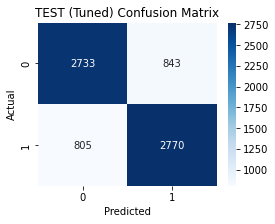

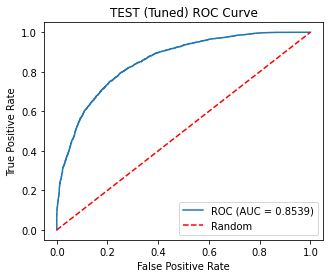

TEST (Tuned) AUC: 0.8539

===== Comparison of Test Performance to CV Best Score =====
Cross-validation best score (AUC): 0.8484151046622864


In [37]:
best_xgb = xgb.XGBClassifier(
    **grid_search_xgb.best_params_,
    random_state=42,
    scale_pos_weight=class_weights[1] / class_weights[0],
    eval_metric='logloss'
)
best_xgb.fit(X_train, y_train)

print_classification_metrics(best_xgb, X_train, y_train, "TRAIN (Tuned)")
print_classification_metrics(best_xgb, X_val, y_val, "VALIDATION (Tuned)")
print_classification_metrics(best_xgb, X_test, y_test, "TEST (Tuned)")

plot_confusion_matrix_and_roc(best_xgb, X_test, y_test, "TEST (Tuned)")

print("\n===== Comparison of Test Performance to CV Best Score =====")
print("Cross-validation best score (AUC):", grid_search_xgb.best_score_)
